# Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images
Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/)

THe purpose of this notebook is to extract the scattering features.




In [1]:
import sys
sys.path.append('../src')

from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from cld_ivado.utils.dataframe_creation import create_dataframe_preproccessing
from cld_ivado.utils.context import get_context
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from kymatio.torch import Scattering2D
from kymatio import Scattering2D as Scattering2Dnumpy
from cld_ivado.utils.context import get_context
import kymatio.datasets as scattering_datasets
import pickle
import matplotlib.cm as cm
import matplotlib as mpl
from PIL import Image
import os

from pathlib import Path
import yaml



In [2]:
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
#proj_path = current_dir.parent
proj_path = current_dir.parent
# make the code in src available to import in this notebook
sys.path.append(os.path.join(proj_path, 'src'))

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/data_catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)

# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/parameters.yml'), "r") as f:
    params = yaml.safe_load(f)


In [3]:
with open(os.path.join(catalog['data_root'],catalog['02_interim_pd']), 'rb') as handle:
    df = pickle.load(handle)

## Extract Features
In this section, scattering and GLCM features will be extracted. 

### Step 3.1 Extract Scattering Features using Kymatio

In [4]:
M, N= 434, 636 # ultrasound image dimension

In [5]:
# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M,N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M,N)])

100%|██████████| 549/549 [00:07<00:00, 73.43it/s] 


In [6]:
%%time
# This should take about 7 minutes. It processes about 10 images/5sec.
# Set the parameters of the scattering transform.
#J = params['scattering']['J']
J = 6

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a Scattering2D object.
scattering = Scattering2D(J, (M, N), max_order= params['scattering']['max_order'])
if use_cuda: scattering = scattering.cuda()

data = data.to(device)
scattering_features = scattering(data)

/home/gauthiers/.conda/envs/ultra/lib/python3.7/site-packages/kymatio/scattering2d/backend/torch_backend.py:148: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  fft = FFT(lambda x: torch.fft(x, 2, normalized=False),
/home/gauthiers/.conda/envs/ultra/lib/python3.7/site-packages/kymatio/scattering2d/backend/torch_backend.py:150: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  lambda x: torch.irfft(x, 2, normalized=False, onesided=False),
/home/gauthiers/.conda/envs/ultra/lib/python3.7/site-packages/kymatio/sca

CPU times: user 2min 21s, sys: 3.17 s, total: 2min 24s
Wall time: 2min 24s


In [7]:
scattering_features.shape

torch.Size([550, 1009, 6, 9])

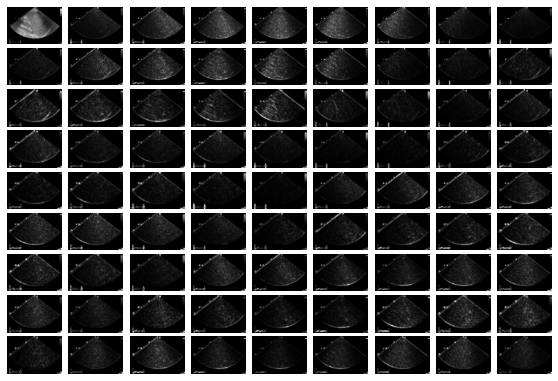

In [7]:
# show images
sf = scattering_features[0].view(scattering_features.shape[1],scattering_features.shape[2], scattering_features.shape[3]).cpu()
npimg = np.uint8(sf)

f, axarr = plt.subplots(9,9, figsize=(scattering_features.shape[3]/8, scattering_features.shape[2]/8))
count = 0
for i in range(0, 9) :
    for j in range(0, 9) :
        axarr[i,j].imshow(sf[count], cmap='gray')
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

# Save scattering features

In [10]:
sc_features = scattering_features.view(scattering_features.shape[0], scattering_features.shape[1] * scattering_features.shape[2] * scattering_features.shape[3])
X = sc_features.cpu().numpy()
df_sc = pd.DataFrame(X)
df_scattering = pd.concat([df['id'], df['class'], df_sc], axis=1)

In [11]:
# Create a dict for the scattering features, and parameters - for model not using tensors
scatter_dict = {'df':df_scattering,
                'J':J,
                'M':M,
                'N':N}

with open(f'../data/03_features/scattering_features_J_{J}.pickle', 'wb') as handle:
    pickle.dump(scatter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)